# calc DP products #

## Software utilizing PyArt to create rainfall products from Dual Pol data.
* Developed by the NASA GPM-GV group.
* V0.2 - 01/14/2021 - update by Jason Pippitt NASA/GSFC/SSAI

<table><tr>
<td> <img src="./images/nasa.jpg" alt="NASA" style="width: 250px;"/> </td>
<td> <img src="./images/GPM.jpg" alt="GPM" style="width: 250px;"/> </td>
</tr></table>

## First we import functions needed to run calc_DP_products.

In [1]:
from __future__ import print_function
import numpy as np
import pyart
import glob
import ast
import sys
import os
import argparse
import datetime
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain,
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
import warnings

sys.path.append('../scripts/')
import plot_dpqc_images as pltqc
import gpm_dp_utils as gu
import gpm_dpqc as gpm

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Specify which file to run.  We will use a default thresh_dict for this notebook, variables will print below.

In [2]:
file = './cf/NPOL1_2020_0910_215040_PPI.cf'

#Import thresholds and in out dirs

DP_product_dict = gpm.get_default_product_dict()

print('DP products parameters:    ')
print(DP_product_dict)

print()
print('<-- ' + file)
fileb = os.path.basename(file)

# Load radar object
radar = pyart.io.read(file, file_field_names=True)

DP products parameters:    
{'cf_dir': './cf/', 'max_range': 150, 'max_height': 10, 'sweeps_to_plot': [0], 'output_cf': True, 'output_fields': ['DZ', 'CZ', 'VR', 'DR', 'KD', 'PH', 'RH', 'SD', 'SQ', 'FH', 'RC', 'DM', 'NW'], 'plot_images': True, 'plot_single': False, 'fields_to_plot': ['CZ', 'RC', 'FH', 'DM', 'NW'], 'plot_dir': './plots/', 'use_sounding': True, 'sounding_type': 'ruc_archive', 'sounding_dir': './soundings/'}

<-- ./cf/NPOL1_2020_0910_215040_PPI.cf


## Create Temperature field and declare variables.

In [3]:
# Create Temperature field
if DP_product_dict['use_sounding'] == True:
    if DP_product_dict['sounding_type'] == 'ruc':
        radar = gpm.use_ruc_sounding(radar, DP_product_dict)
    if DP_product_dict['sounding_type'] == 'uwy':
        radar = gpm.use_uwy_sounding(radar, DP_product_dict)
    if DP_product_dict['sounding_type'] == 'ruc_archive':
        radar = gpm.get_ruc_sounding(radar, DP_product_dict)
if DP_product_dict['use_sounding'] == False:
    radar = gpm.get_beam_height(radar) 

dz = radar.fields['CZ']['data']
dr = radar.fields['DR']['data']
kd = radar.fields['KD']['data']
rh = radar.fields['RH']['data']
radar_T = radar.fields['TEMP']['data']
radar_z = radar.fields['HEIGHT']['data']


Interpolating sounding to radar structure...
Sounding file -->  ./soundings/2020/0910/NPOL/NPOL_2020_0910_22UTC.txt



## Calculate HID, rain rates, and DSD products.

In [4]:
# Get HID scores and add FH to radar

print('Add HID field to radar...')
radar_band = 'S'
radar, fh = gu.add_csu_fhc(radar, dz, dr, rh, kd, radar_band, radar_T)

# Calculate Cifelli et al. 2011 ice and water mass fields and add to radar.
# Function expects, reflectivity, differential reflectivity,
# and altitude (km MSL) at a minimum. Temperature is optional.
print('Calculating water and ice mass...')
radar = gu.add_csu_liquid_ice_mass(radar, dz, dr, radar_z/1000.0, radar_T)

# Calculate Blended-rain from Cifelli et al. 2011 and addr to radar
print('Calculating blended rainfall field...')
radar = gu.add_csu_blended_rain(radar, dz, dr, kd, fh)
    
# Calculate Drop-Size Distribution from Tokay et al. 2020 and add to radar
print('Calculating Drop-Size Distribution...')
radar = gu.add_calc_dsd_sband_tokay_2020(radar, dz, dr, 'wff')

Add HID field to radar...
Calculating water and ice mass...
Calculating blended rainfall field...
Calculating Drop-Size Distribution...


## Create plots of new fields.


Plotting PPI images...
  --> ./plots//NPOL1_2020_0910_215040_5panel_sw00_PPI.png



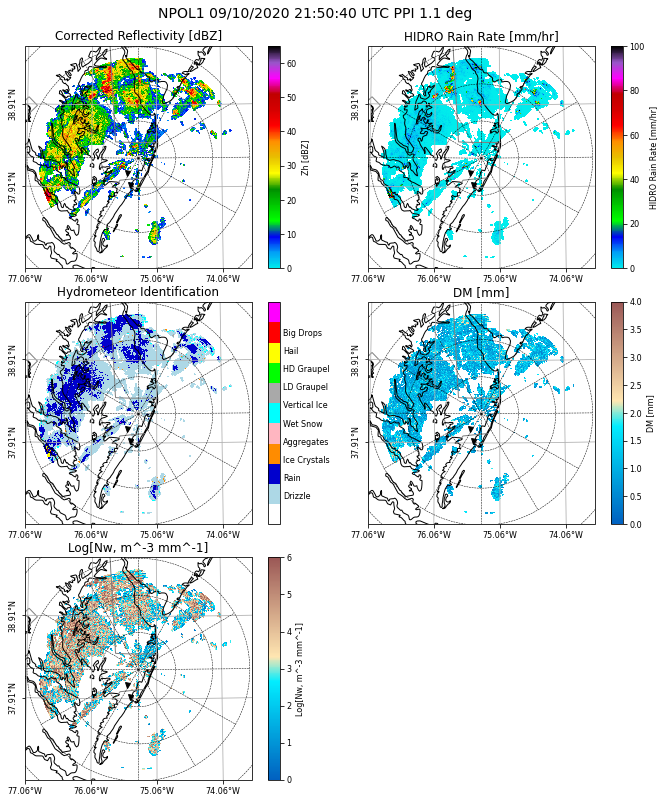

In [5]:
# Plot radar images
if DP_product_dict['plot_images'] == True:
    print()
    pltqc.plot_fields(radar, DP_product_dict)

## Output cfRadial file with rainfall products.

In [6]:
# Remove unwanted fields from radar and write cfRadial
if DP_product_dict['output_cf'] == True:
    gu.remove_undesirable_fields(radar, DP_product_dict)
    # Write cfRadial file
    gpm.output_cf(radar, DP_product_dict)

Removing unwanted fields...
CF FIELDS -->  
dict_keys(['DZ', 'VR', 'DR', 'KD', 'PH', 'RH', 'SQ', 'CZ', 'SD', 'FH', 'RC', 'DM', 'NW'])

Output cfRadial --> ./cf//NPOL1_2020_0910_215040_PPI.cf

